In [1]:
%%html
<!--Run this before presenting!-->
<style>
table {float:left}
</style>

# Baler - Machine Learning Based Data Compression Tool

*Alexander Ekman, Axel Gallén, Pratik Jawahar*\
*Caterina Doglioni, Oxana Smirnova*

https://github.com/baler-collaboration/baler



# The Probelm
* “Data deluge”: when the sheer volume of new data being generated is overwhelming the storage and processing capacities
* An increasingly common problem in both academia and industry.
<div>
<img src="figures/data_deluge.png" width="700"/>
</div>


## The Solution
* One approach: Lossy compression (Like mp3 for music)
* One catch: Lossy compression needs to be tailored
* Solution: Lossy Machine Learning based compression
<div>
<img src="figures/AE.png" width="900"/>
</div>



# Our Tool: “Baler”
* We have created a tool called “Baler” to help investigate the viability of this compression
* **Big News:** now available as a pip package!

In [2]:
!pip install baler-compressor
    
import baler_compressor.config as config_module
import baler_compressor.trainer as trainer_module
import baler_compressor.compressor as compressor_module
import baler_compressor.decompressor as decompressor_module

import torch
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


* Distributed and developed as an open source project
    - https://github.com/baler-collaboration/baler

## X-ray tomography Input Data (exafel_1)

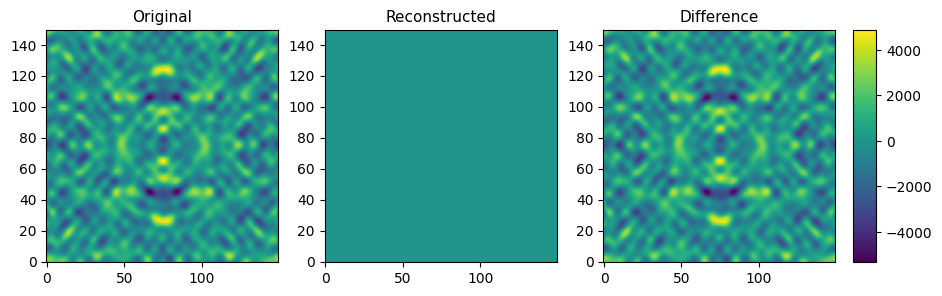

In [3]:
import helper

data = np.load("input/exafel_1.npz")["data"]
data_decompressed = data*0

helper.plot2D(data[0], data_decompressed[0])

## Baler Workflow
<div>
<img src="figures/workflow.png" width="800"/>
</div>

## Define Training Parameters (config file)

In [4]:
config = config_module.Config
config.compression_ratio = 1000
config.epochs = 1
config.early_stopping = False
config.early_stopping_patience = 100
config.min_delta = 0
config.lr_scheduler = True
config.lr_scheduler_patience = 50
config.model_name = "CFD_dense_AE"
config.model_type = "dense"
config.custom_norm = True
config.l1 = True
config.reg_param = 0.001
config.RHO = 0.05
config.lr = 0.001
config.batch_size = 75
config.test_size = 0.2
config.data_dimension = 2
config.apply_normalization = False
config.deterministic_algorithm = False
config.compress_to_latent_space = False
config.convert_to_blocks = [1, 150, 150]
config.verbose = False


input_data_path = "input/exafel_1.npz"
output_path = "output/"
model_path = output_path + "compressed_output/model.pt"
normalization_path = output_path + "compressed_output/normalization_features.npy"
compressed_path = output_path + "compressed_output/compressed.npz"
decompressed_path = output_path + "decompressed_output/decompressed.npz"


## Training
| Parameters | Returns |
| :---: | :---: |
| Data path | Trained pyTorch model |
|Config|Normalization features|
||Loss data|

In [5]:
model, normalization, loss_data = trainer_module.run(input_data_path, config)

Epoch 1 of 1
### Beginning Training


  0%|          | 0/1 [00:00<?, ?it/s]

# Finished. Training Loss: 865082816.000000
### Beginning Validating


  0%|          | 0/1 [00:00<?, ?it/s]

# Finished. Validation Loss: 223291808.000000
Training took: 0.00281 minutes


# Saving model and normalization to disk

In [6]:
torch.save(model.state_dict(), model_path)
np.save(normalization_path,normalization)

### Using pre-trained model
* 1000 Epochs, 2 minutes, 36.3 MB

In [ ]:
# Use pre trained model:
model_path = output_path + "compressed_output/model_preBaked.pt"

## Compression
| Parameters | Returns |
| :---: | :---: |
|Data path|Compressed data|
|Model path|Column names|
|Normalization features|Original shape|
|Config||

In [ ]:
compressed, names, original_shape = compressor_module.run(input_data_path, model_path,normalization, config)


## Saving compressed data to disk
* We can save the returns to disk as the decompressed data

In [ ]:
print("Latent space:\n",compressed[0])
np.savez_compressed(
    compressed_path,
    data=compressed,
    names=names,
    normalization_features=normalization,
    original_shape=original_shape,
)

## Running Decompression
| Parameters | Returns |
| :---: | :---: |
|Model path|Decompressed data|
|Compressed path|Column names|
|Config|Original shape|

In [ ]:
decompressed, names, original_shape = decompressor_module.run(model_path, compressed_path, config)

## Saving decompressed data  to disk

In [ ]:
np.savez(decompressed_path, data=decompressed, names=names)

## Evaluating performance
* Use extrenal plotting to look at performance

In [ ]:
data = np.load("input/exafel_1.npz")["data"]
data_decompressed = np.load("output/decompressed_output/decompressed.npz")["data"].reshape(data.shape[0], data.shape[1], data.shape[2])
helper.plot2D(data[10], data_decompressed[10])

* **But!** The model is larger than the original file size

## Offline vs Online compression
* Offline compression is always done on data which is fully aquired
    - A single model is then derived for that one dataset
    - Auxilliary files decrease or ruin performance
* Online compression can be done on data in real time
    - Uses a model derived on similar, previously aquired datasets
    - Auxilliary files do not count towards final compressed file size

## Demonstrating online compression
* New, but similar, dataset "exafel_2"
* Same model as was derived from "exafel_1"

In [ ]:
# Run compression
compressed, names, original_shape = compressor_module.run(
    "input/exafel_2.npz",
    model_path,
    normalization,
    config,
)
# Save compressed file
np.savez_compressed(
    output_path + "compressed_output/compressed2.npz",
    data=compressed,
    names=names,
    normalization_features=normalization,
    original_shape=original_shape,
)
# Run decompression
decompressed, names, original_shape = decompressor_module.run(
    model_path,
    output_path + "compressed_output/compressed2.npz",
    config,
)
# Save decompressed file
np.savez(
    output_path + "decompressed_output/decompressed2.npz",
    data=decompressed,
    names=names,
)

## Evaluation of Online compression
* We have compressed a file down to 0.001% its original size
<div>
<img src="figures/size.png" width="400"/>
</div>
* And this is the reconstruction

In [ ]:
import helper
data = np.load("input/exafel_2.npz")["data"]
data_decompressed = np.load("output/decompressed_output/decompressed2.npz")["data"].reshape(data.shape[0], data.shape[1], data.shape[2])
helper.plot2D(data[10], data_decompressed[10])

## Outlook
* The interest for machine learning based offline compresion is limited
* The interest for online compression is unlimited?
    - Telecom
    - Autonomous vehicles
    - Detector readout
    - Anything with bandwidth constraints
* Two master students with Ericsson this spring
* Applied for grant together with MAX IV
    0.5% Original Size (Offline)             |  0.001% Original Size (Online)
:-------------------------:|:-------------------------:
![](figures/CFD.gif)  |  ![](figures/xray.gif)



<p style="text-align: center;"> <b>65% Original Size</b>
<div>
<img src="figures/HEP.png" width="800"/>
</div>
</p>